# Handling missing data

Missing values reflect a data generation process: values are missing for a reason. We need to understand (or at least hypothesize) why data is missing to choose missing value imputation methods that are
- statistically valid
- avoid introducing bias

## Classical categories of missingness
### MCAR — Missing Completely At Random
**Interpretation**: Whether a value is missing is unrelated to anything in the dataset.

**Example scenarios**

- A random software glitch causes some rows to be dropped entirely.

- A sensor occasionally fails independent of environmental conditions.

- Survey forms were lost in the mail randomly.

**Practical implication**

Under MCAR, analyzing only complete cases does not create systematic bias (but reduces sample size and efficiency), thus

- Complete case analysis is often acceptable (unbiased) but wastes data.
- Imputation tends to work well; many simple methods are “good enough.”

### MAR — Missing At Random
Interpretation: Missingness is “explainable” using variables we actually observed.

Example scenarios

- In a survey, people in certain known groups are less likely to answer income questions.

  - Example: for respondents with observed education level / age group, salary nonresponse differs.

- In simulation experiments, the model crashes for certain observed input conditions.

  - Example: for large observed parameter values, the simulation becomes unstable and output becomes missing.

Practical implication

- Under MAR, methods that properly condition on predictors can still be valid. If missingness is independent of the response conditional on the predictors, linear regression remains valid (conceptually: conditioning blocks the dependence).

- Naive imputation may distort relationships depending on the analysis goal.

- But imputation methods can introduce bias, depending on:

  - whether the imputation uses the response variable,

  - whether your analysis depends on correlations/variance (most do),

  - whether uncertainty is propagated.



### MNAR — Missing Not At Random
Interpretation: Missingness is informative about the missing value.

**Example scenarios**

- Pollutant sensor detection limit: the sensor only records values above a threshold; low values are “missing.”

  - Here missingness depends on the actual (unobserved) pollutant concentration.

- Storm surges only occur in areas below water level

  - The surge measurements are missing in regions that never become inundated; missingness depends on latent flood conditions.

**Practical implication**

- Under MNAR, missingness itself must be modeled explicitly.

  - For example, censored observations in survival analysis, where the censoring mechanism is part of the model.

- Standard imputation can lead to strong bias unless missingness is handled carefully.

## Imputation experiment
We impute missing values for column `ActualElapsedTime` from `airline_2019.csv` using:
- constant imputation
- MICE (iterative imputer with posterior sampling; PMM if `miceforest` is available)
- k-nearest neighbors (KNN) imputation

We compare methods using:
- RMSE and correlation on a held-out missingness mask (numeric columns only)
- correlation matrix preservation


In [31]:
# %pip install missingno
# %pip install miceforest
# %pip install plotnine

In [32]:
import pandas as pd
import missingno as msno
import miceforest as mf
import plotnine
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer

In [33]:
## Change the file location to your saved location
FILE_LOCATION = 'airline_2019.csv'


In [34]:
USE_COLS = [
    "Year",
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "DepTime",
    "CRSDepTime",
    "ArrTime",
    "CRSArrTime",
    "Reporting_Airline",
    "Flight_Number_Reporting_Airline",
    "Tail_Number",
    "ActualElapsedTime",
    "CRSElapsedTime",
    "AirTime",
    "ArrDelay",
    "DepDelay",
    "Origin",
    "Dest",
    "Distance",
    "TaxiIn",
    "TaxiOut",
    "Cancelled",
    "CancellationCode",
    "Diverted",
    "CarrierDelay",
    "WeatherDelay",
    "NASDelay",
    "SecurityDelay",
    "LateAircraftDelay",
]


In [35]:
df_2019 = pd.read_csv(FILE_LOCATION, usecols = USE_COLS)


In [36]:
numeric_cols = df_2019.select_dtypes(include="number").columns.tolist()
categorical_cols = [c for c in USE_COLS if c not in numeric_cols]

In [37]:
categorical_cols

['Reporting_Airline', 'Tail_Number', 'Origin', 'Dest', 'CancellationCode']

In [38]:
missing_summary = df_2019[USE_COLS].isna().mean().sort_values(ascending=False)
missing_summary

CancellationCode                   0.981675
LateAircraftDelay                  0.813159
SecurityDelay                      0.813159
NASDelay                           0.813159
WeatherDelay                       0.813159
CarrierDelay                       0.813159
ActualElapsedTime                  0.020805
AirTime                            0.020805
ArrDelay                           0.020805
TaxiIn                             0.018795
ArrTime                            0.018795
TaxiOut                            0.018195
DepTime                            0.017581
DepDelay                           0.017581
Tail_Number                        0.002741
CRSElapsedTime                     0.000039
Cancelled                          0.000000
DayofMonth                         0.000000
DayOfWeek                          0.000000
CRSDepTime                         0.000000
Diverted                           0.000000
Flight_Number_Reporting_Airline    0.000000
Distance                        

<Axes: >

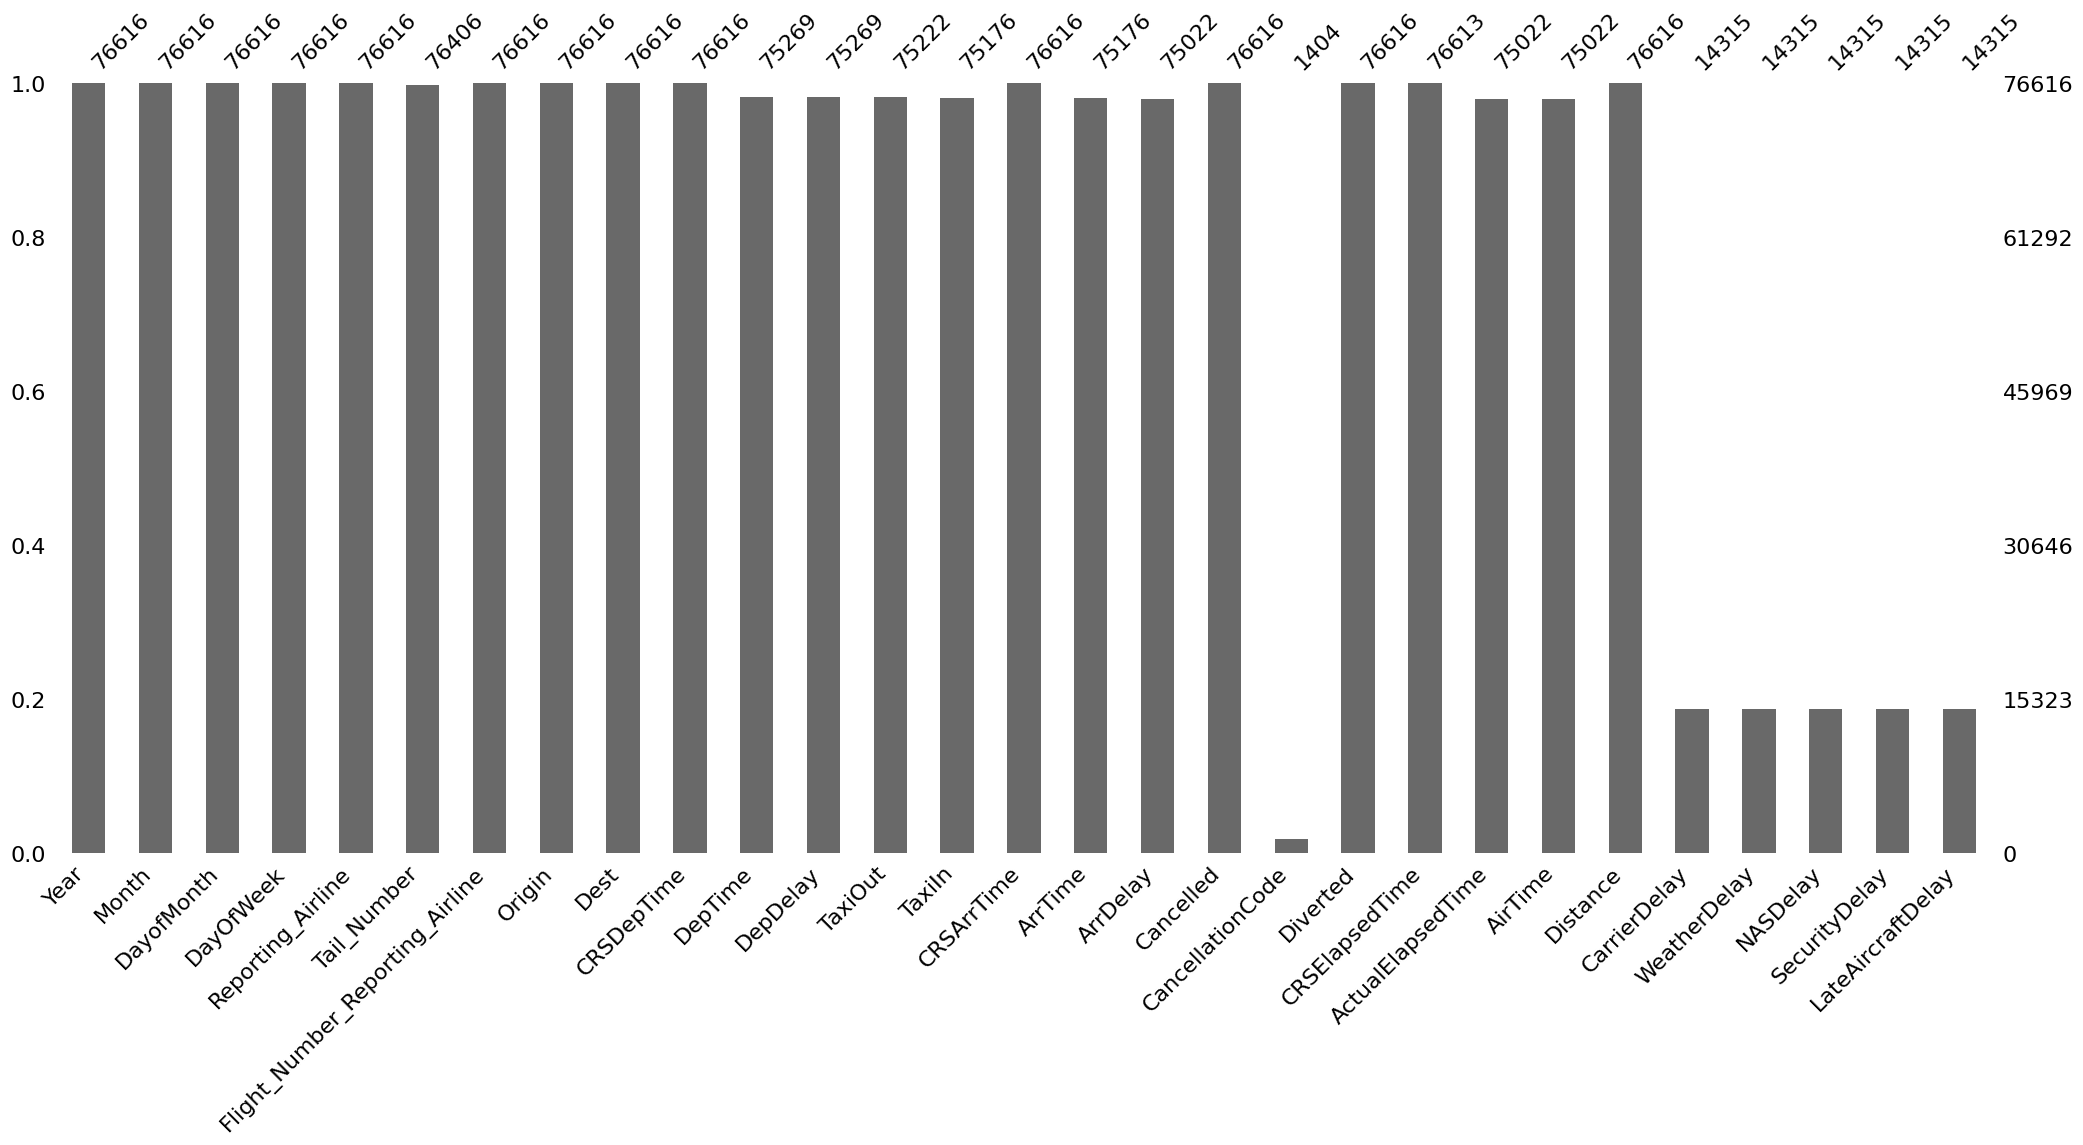

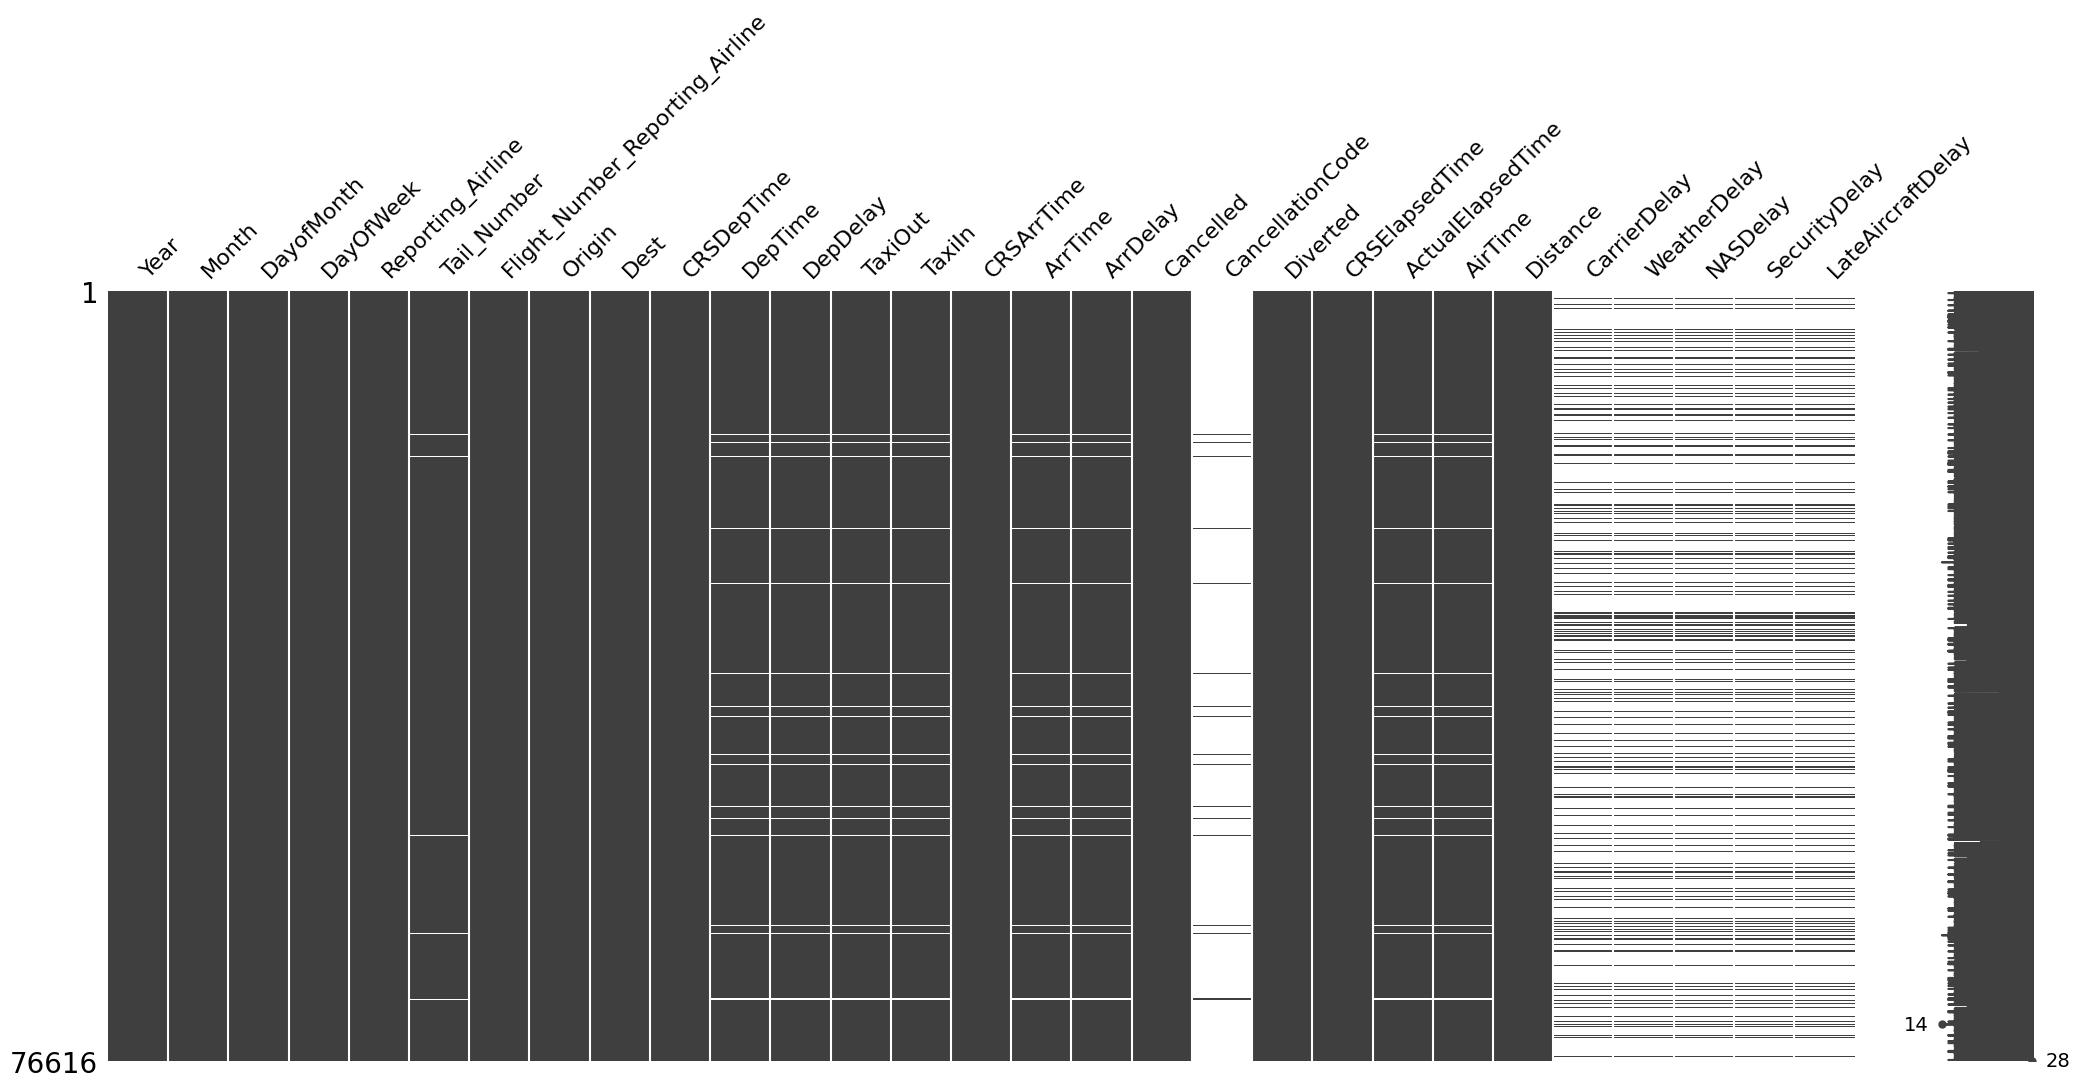

In [39]:
msno.bar(df_2019)
msno.matrix(df_2019)


### Build Holdout Mask
It a boolean mask (same shape as your dataframe) that marks a random subset of currently-observed entries to be held out / artificially treated as missing.

This performs the similar function as removing whole column data in class example. This is to enable us to compre imputed and roginal true values and calculated metrics (e.g., RMSE).

In [40]:
import numpy as np

target_col = "ActualElapsedTime"
seed = 42
missing_rate = 0.10

rng = np.random.default_rng(seed)
observed_mask = df_2019[target_col].notna()
holdout_mask = (rng.random(len(df_2019)) < missing_rate) & observed_mask

df_masked = df_2019.copy()
df_masked.loc[holdout_mask, target_col] = np.nan

holdout_mask.sum()

7399

### Method 1: Simple Imputation with a constant

In [ ]:
df_2019.loc[holdout_mask, [target_col]].head()

,ActualElapsedTime
4,65.0
17,166.0
27,127.0
68,123.0
74,116.0


In [ ]:
df_masked[target_col].median()

119.0

In [ ]:
# Constant imputation
constant_fill = df_2019[target_col].median()
df_const = df_masked.copy()
df_const[target_col] = df_const[target_col].fillna(constant_fill)
df_const[target_col].isna().sum()
df_const[target_col].describe()

count    76616.000000
mean       134.482562
std         68.336504
min         16.000000
25%         88.000000
50%        119.000000
75%        159.000000
max        665.000000
Name: ActualElapsedTime, dtype: float64

In [ ]:
def evaluate_method(label, df_imputed):
    y_true = df_2019.loc[holdout_mask, target_col].astype(float)
    y_pred = df_imputed.loc[holdout_mask, target_col].astype(float)
    valid = y_true.notna() & y_pred.notna()

    if valid.sum() == 0:
        rmse = np.nan
        corr = np.nan
    else:
        rmse = float(np.sqrt(np.mean((y_true[valid] - y_pred[valid]) ** 2)))
        corr = float(np.corrcoef(y_true[valid], y_pred[valid])[0, 1])

    return {"method": label, "rmse": rmse}

In [ ]:
evaluate_method("Constant", df_const)

c:\0-Kathy Cui\0-Northwestern\0-Classes\3rd Year\Spring 2025\CS352\.conda\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
c:\0-Kathy Cui\0-Northwestern\0-Classes\3rd Year\Spring 2025\CS352\.conda\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide


{'method': 'Constant', 'rmse': 75.19771479448166}

In [ ]:
corr = df_2019.select_dtypes('number').corr()
corr_const = df_const.select_dtypes('number').corr()

corr - corr_const

,Year,Month,DayofMonth,DayOfWeek,Flight_Number_Reporting_Airline,CRSDepTime,DepTime,DepDelay,TaxiOut,TaxiIn,...,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
Year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Month,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.000000,-0.003221,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DayofMonth,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.000000,-0.000542,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DayOfWeek,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.000000,0.001187,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Flight_Number_Reporting_Airline,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.000000,-0.019281,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CRSDepTime,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.000000,-0.001437,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DepTime,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.000000,-0.002751,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DepDelay,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.000000,0.001512,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TaxiOut,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.000000,0.011060,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TaxiIn,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.000000,0.012004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Method 2: MICE (PMM) with miceforest
key function
```python
kernel = mf.ImputationKernel(
    df_masked[numeric_cols].astype(float),
    datasets=1,
    save_all_iterations=False,
    random_state=seed,
    mean_match_candidates=5,
)
kernel.mice(mice_iters)
df_mice_num = kernel.complete_data(dataset=0)
```

In [ ]:
mice_iters = 5

kernel = mf.ImputationKernel(
    df_masked[numeric_cols].astype(float),
    num_datasets=1,
    random_state=seed,
    mean_match_candidates=5
)
kernel.mice(mice_iters)
df_mice_num = kernel.complete_data(dataset=0)

In [ ]:
df_mice = df_masked.copy()
df_mice[numeric_cols] = df_mice_num

In [ ]:
evaluate_method("MICE", df_mice)

{'method': 'MICE', 'rmse': 7.444210667979017}

In [ ]:
corr = df_2019.select_dtypes('number').corr()
corr_mice = df_mice.select_dtypes('number').corr()

corr - corr_mice

,Year,Month,DayofMonth,DayOfWeek,Flight_Number_Reporting_Airline,CRSDepTime,DepTime,DepDelay,TaxiOut,TaxiIn,...,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
Year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Month,NaN,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000014,-0.002639,0.009149,0.020124,...,0.000000,-4.682071e-05,-0.002379,-0.001661,0.000000e+00,0.011587,-0.007807,-0.000858,0.019325,0.008667
DayofMonth,NaN,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-0.000306,-0.000456,-0.004576,-0.007718,...,0.000000,-2.996978e-06,0.000702,0.000715,0.000000e+00,0.005404,-0.007153,0.004277,0.032117,-0.002904
DayOfWeek,NaN,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-0.000575,0.001944,-0.001230,0.003564,...,0.000000,6.989202e-07,0.000066,0.000178,0.000000e+00,0.005007,-0.002269,-0.002909,-0.005817,-0.003945
Flight_Number_Reporting_Airline,NaN,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-0.001395,-0.005035,-0.004202,-0.016309,...,0.000000,1.848488e-05,-0.000248,-0.000891,0.000000e+00,0.006541,0.017065,-0.002103,0.009484,0.026667
CRSDepTime,NaN,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000617,-0.003361,-0.012813,-0.022107,...,0.000000,-1.139146e-06,-0.000028,0.000096,0.000000e+00,-0.058369,0.010956,-0.045851,0.031030,0.022785
DepTime,NaN,0.000014,-0.000306,-5.747399e-04,-0.001395,0.000617,0.000000,0.000237,-0.008883,-0.016676,...,0.000132,-1.179771e-05,-0.000494,-0.000435,2.017124e-04,-0.069015,0.000869,-0.033900,0.039869,0.000247
DepDelay,NaN,-0.002639,-0.000456,1.944020e-03,-0.005035,-0.003361,0.000237,0.000000,-0.044987,-0.067529,...,0.001689,2.995448e-03,0.002383,0.001368,3.312216e-03,0.023536,0.075118,-0.021057,0.064812,-0.094922
TaxiOut,NaN,0.009149,-0.004576,-1.230198e-03,-0.004202,-0.012813,-0.008883,-0.044987,0.000000,-0.155577,...,0.002603,1.221465e-02,0.023748,0.006138,9.833111e-03,-0.075356,0.005086,0.025655,0.039695,-0.157848
TaxiIn,NaN,0.020124,-0.007718,3.563673e-03,-0.016309,-0.022107,-0.016676,-0.067529,-0.155577,0.000000,...,0.007361,2.476745e-02,0.043596,0.014928,2.138210e-02,-0.049520,-0.018982,0.033749,0.031687,-0.079365


### Method 3: KNN imputation
Key function
```python
knn_imputer = KNNImputer(n_neighbors=knn_k)
df_knn_num = pd.DataFrame(
    knn_imputer.fit_transform(df_masked[numeric_cols].astype(float)),
    columns=numeric_cols,
    index=df_masked.index,
)
```

In [ ]:
knn_imputer = KNNImputer(n_neighbors=5)
df_knn_num = pd.DataFrame(
    knn_imputer.fit_transform(df_masked[numeric_cols].astype(float)),
    columns=numeric_cols,
    index=df_masked.index,
)

In [ ]:
df_knn = df_masked.copy()
df_knn[numeric_cols] = df_knn_num

In [ ]:
evaluate_method("KNN", df_knn)

{'method': 'KNN', 'rmse': 15.395505756979128}

In [ ]:
corr = df_2019.select_dtypes('number').corr()
corr_knn = df_knn.select_dtypes('number').corr()

corr - corr_knn

,Year,Month,DayofMonth,DayOfWeek,Flight_Number_Reporting_Airline,CRSDepTime,DepTime,DepDelay,TaxiOut,TaxiIn,...,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
Year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Month,NaN,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000264,-0.000077,-0.000457,-0.000182,...,0.000000,-4.640782e-05,-0.003373,-0.002321,0.000000e+00,0.013944,-0.007761,0.000752,0.006473,0.008496
DayofMonth,NaN,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-0.000530,-0.000246,0.000296,-0.000314,...,0.000000,-2.540627e-06,0.000996,0.000898,0.000000e+00,0.004273,-0.001901,0.009113,-0.003902,-0.004786
DayOfWeek,NaN,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-0.000625,-0.000020,-0.000260,0.000230,...,0.000000,1.895953e-07,-0.000411,-0.000023,0.000000e+00,0.006301,-0.000998,-0.005406,0.012859,-0.003064
Flight_Number_Reporting_Airline,NaN,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-0.001899,-0.000208,-0.000954,-0.000435,...,0.000000,1.810101e-05,0.000036,-0.000386,0.000000e+00,0.012487,0.014022,-0.002705,0.011760,0.010784
CRSDepTime,NaN,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-0.000638,-0.000900,-0.000734,-0.000166,...,0.000000,-2.669946e-06,0.000193,0.000560,0.000000e+00,-0.042880,-0.012800,0.049961,0.028352,-0.092760
DepTime,NaN,0.000264,-0.000530,-6.252114e-04,-0.001899,-0.000638,0.000000,-0.000782,-0.000690,-0.000234,...,0.000182,3.145194e-04,-0.000530,0.000325,4.922887e-04,-0.051529,-0.023055,0.057883,0.031455,-0.106573
DepDelay,NaN,-0.000077,-0.000246,-2.016254e-05,-0.000208,-0.000900,-0.000782,0.000000,0.000140,0.000203,...,0.000056,1.369128e-04,-0.000432,0.000569,1.380472e-04,0.053689,0.016225,-0.002283,0.000803,-0.028091
TaxiOut,NaN,-0.000457,0.000296,-2.603601e-04,-0.000954,-0.000734,-0.000690,0.000140,0.000000,-0.000173,...,0.000061,3.537654e-04,0.011853,0.000350,3.310676e-04,-0.060462,-0.011517,0.041129,-0.000397,-0.110569
TaxiIn,NaN,-0.000182,-0.000314,2.299304e-04,-0.000435,-0.000166,-0.000234,0.000203,-0.000173,0.000000,...,0.004078,-1.902496e-04,0.007602,0.000141,-1.991026e-04,-0.033627,-0.011846,0.045889,0.003688,-0.043660


## Summary/Takeaways
In practice:

- MCAR → complete-case or simple imputation often okay

- MAR → regression/likelihood-based methods can be valid; naive imputation can bias results

- MNAR → must model missingness explicitly (or do sensitivity analysis)

Imputation quality should be evaluated both by:

- predictive error (e.g., RMSE when truth is known),

- structure preservation (e.g., correlation matrix).
